# Introduction

## Why style transfer?
It is an interesting idea to attempt to transfer the style of one object (in this case a painting) and attach it to another object (an actual image). This could allow us to easily create new artwork with styles that we like.

## How do we solve it?
The method we use to solve it in this project is cycleGANs. In this method we have 4 individual models (2 generators and 2 discriminators) and we attempt to reduce the loss in all of them at the same time.

## Where did the data come from?
The data was taken from the "I'm something of a Painter Myself" competition on kaggle and consists of 300 monet paintings in .jpg format and 7028 real photos in .jpg format

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow_addons as tfa

2024-12-09 04:53:49.042831: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-09 04:53:49.072881: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-09 04:53:49.072910: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-09 04:53:49.072925: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-09 04:53:49.079490: I tensorflow/core/platform/cpu_feature_g

In [2]:
# first lets make a function that will load an image as a tensor
def load_image(fileName):
    file = tf.io.read_file(fileName)
    imageTensor = tf.io.decode_jpeg(file)
    imageTensor = tf.cast(imageTensor, tf.float32)
    return imageTensor
    

In [3]:
cwd = os.getcwd()
cwd
MonetDir = cwd + '/Paint/monet'
PhotoDir = cwd + '/Paint/photo'
MonetImages = os.listdir(MonetDir)
PhotoImages = os.listdir(PhotoDir)

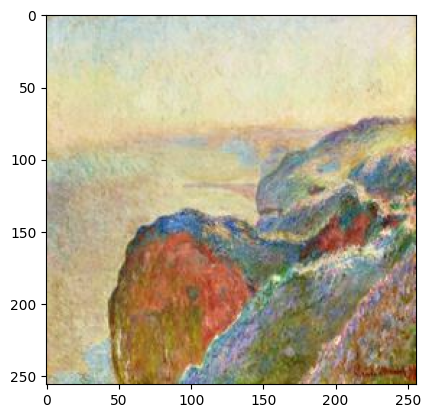

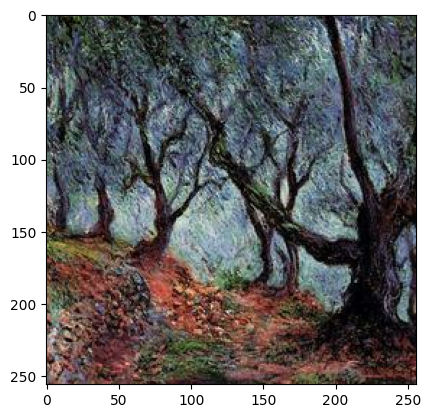

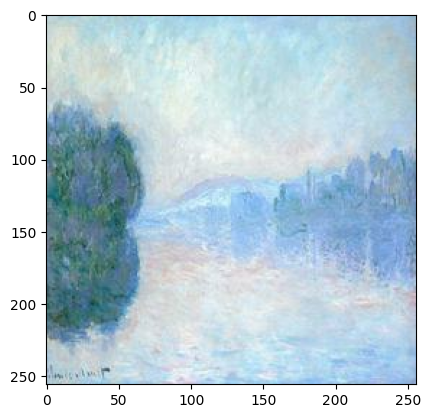

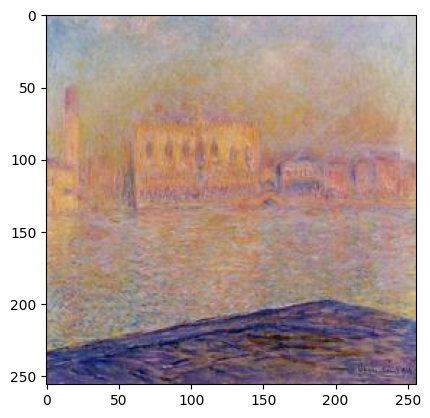

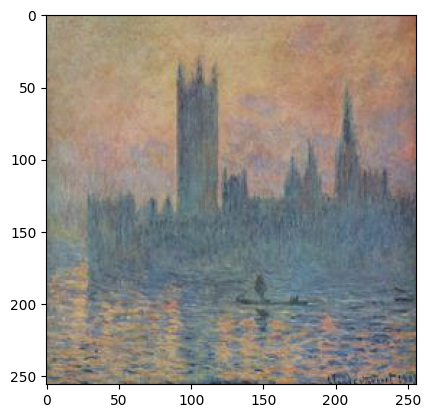

In [5]:
plt.figure()
for i in range(5):
    plt.imshow(load_image(MonetDir + '/' + MonetImages[i])/255)
    plt.show()

Our data for both sets of images are 256x256 RGB images.

# Data Preprocessing
We will be using code from the pix2pix paper(https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/pix2pix.ipynb) to design our cycle gan. This requires some preprocessing functions to add noise/jitter.

In [6]:
def resize(image, height, width):
    return tf.image.resize(image, [height,width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

def randomCrop(image):
    return tf.image.random_crop(image, size=[256, 256, 3])

def normalize(image):
    return ((image / 127.5) - 1)


@tf.function()
def random_jitter(image):
    # Resizing to 286x286
    image = resize(image, 286, 286)
    
    # Random cropping back to 256x256
    image = randomCrop(image)

    if tf.random.uniform(()) > 0.5:
        # Random mirroring
        image = tf.image.flip_left_right(image)

    return image

    

In [8]:
def load_image_train(image_file):
    image = load_image(image_file)
    image = random_jitter(image)
    image = normalize(image)

    return image

## Batch shuffle, batch, and apply noise to train data

In [9]:
BATCH_SIZE = 4
trainMonet = tf.data.Dataset.list_files(MonetDir + '/*.jpg')
trainMonet = trainMonet.map(load_image_train,num_parallel_calls=tf.data.AUTOTUNE)
trainMonet = trainMonet.shuffle(300).batch(BATCH_SIZE)
trainMonet

<_BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>

In [10]:
trainPhotos = tf.data.Dataset.list_files(PhotoDir + '/*.jpg')
trainPhotos = trainPhotos.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
trainPhotos = trainPhotos.shuffle(7028).batch(BATCH_SIZE)
trainPhotos

<_BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>

# Model Creation

## Original Project's Model
We will start by using the same model used in the original project. This model uses a downsample and upsample function to create its generator and discriminator. These functions 

In [11]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                               kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tfa.layers.InstanceNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [12]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))

    result.add(tfa.layers.InstanceNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [17]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
        downsample(128, 4),  # (batch_size, 64, 64, 128)
        downsample(256, 4),  # (batch_size, 32, 32, 256)
        downsample(512, 4),  # (batch_size, 16, 16, 512)
        downsample(512, 4),  # (batch_size, 8, 8, 512)
        downsample(512, 4),  # (batch_size, 4, 4, 512)
        downsample(512, 4),  # (batch_size, 2, 2, 512)
        downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
        upsample(512, 4),  # (batch_size, 16, 16, 1024)
        upsample(256, 4),  # (batch_size, 32, 32, 512)
        upsample(128, 4),  # (batch_size, 64, 64, 256)
        upsample(64, 4),  # (batch_size, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(3, 4,
                                           strides=2,
                                           padding='same',
                                           kernel_initializer=initializer,
                                           activation='tanh')  # (batch_size, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')


    down1 = downsample(64, 4, False)(inp)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)
    
    batchnorm1 = tfa.layers.InstanceNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

## A few different of my own Generator functions.
For these functions each one envolves a encoder that will downsample to a size of (batch, 1, 1, filters) and then a decoder or upsample that will be size (batch, 256, 256, 3). Some of the different methods attempted here involve skip connections similar to U-Net, Pooling layers, and different filter sizes

In [14]:
def newGenerator():
    inputLayer = tf.keras.layers.Input(shape = (256,256,3))
    # down stack
    hiddenLayer = tf.keras.layers.Conv2D(filters=32, kernel_size=(4,4), strides=(2,2), padding='same')(inputLayer)
    hiddenLayer = tf.keras.layers.LeakyReLU()(hiddenLayer) # outputs (128,128,32)
    shortcut1 = hiddenLayer
    
    hiddenLayer = tf.keras.layers.Conv2D(filters = 64, kernel_size=(4,4), strides = (2,2), padding = 'same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.LeakyReLU()(hiddenLayer) # outputs (64,64,64)
    shortcut2 = hiddenLayer

    hiddenLayer = tf.keras.layers.Conv2D(filters = 128, kernel_size=(4,4), strides = (2,2), padding='same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.LeakyReLU()(hiddenLayer) # outputs (32, 32, 128)
    shortcut3 = hiddenLayer
    
    hiddenLayer = tf.keras.layers.Conv2D(filters = 256, kernel_size=(4,4), strides = (2,2), padding='same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.LeakyReLU()(hiddenLayer) # outputs (16, 16, 256)
    shortcut4 = hiddenLayer

    hiddenLayer = tf.keras.layers.Conv2D(filters = 512, kernel_size=(4,4), strides = (2,2), padding='same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.LeakyReLU()(hiddenLayer) # outputs (8, 8, 512)
    shortcut5 = hiddenLayer

    hiddenLayer = tf.keras.layers.Conv2D(filters = 512, kernel_size=(4,4), strides = (2,2), padding='same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.LeakyReLU()(hiddenLayer) # outputs (4, 4, 512)
    shortcut6 = hiddenLayer

    hiddenLayer = tf.keras.layers.Conv2D(filters = 512, kernel_size=(4,4), strides = (2,2), padding='same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.LeakyReLU()(hiddenLayer) # outputs (2, 2, 512)
    shortcut7 = hiddenLayer

    hiddenLayer = tf.keras.layers.Conv2D(filters = 512, kernel_size=(4,4), strides = (2,2), padding='same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.LeakyReLU()(hiddenLayer) # outputs (1, 1, 512)
    
    # up stack
    hiddenLayer = tf.keras.layers.Conv2DTranspose(filters = 512 , kernel_size=(4,4), strides = (2,2), padding='same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.ReLU()(hiddenLayer) # outputs (2,2,512)

    hiddenLayer = tf.keras.layers.Add()([hiddenLayer, shortcut7])
    hiddenLayer = tf.keras.layers.Conv2DTranspose(filters = 512 , kernel_size=(4,4), strides = (2,2), padding='same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.ReLU()(hiddenLayer) # outputs (4,4,512)

    hiddenLayer = tf.keras.layers.Add()([hiddenLayer, shortcut6])
    hiddenLayer = tf.keras.layers.Conv2DTranspose(filters = 512 , kernel_size=(4,4), strides = (2,2), padding='same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.ReLU()(hiddenLayer) # outputs (8,8,512)

    hiddenLayer = tf.keras.layers.Add()([hiddenLayer, shortcut5])
    hiddenLayer = tf.keras.layers.Conv2DTranspose(filters = 256 , kernel_size=(4,4), strides = (2,2), padding='same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.ReLU()(hiddenLayer) # outputs (16,16,256)

    hiddenLayer = tf.keras.layers.Add()([hiddenLayer, shortcut4])
    hiddenLayer = tf.keras.layers.Conv2DTranspose(filters = 128 , kernel_size=(4,4), strides = (2,2), padding='same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.ReLU()(hiddenLayer) # outputs (32,32,128)

    hiddenLayer = tf.keras.layers.Add()([hiddenLayer, shortcut3])
    hiddenLayer = tf.keras.layers.Conv2DTranspose(filters = 64 , kernel_size=(4,4), strides = (2,2), padding='same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.ReLU()(hiddenLayer) # outputs (64,64,64)

    hiddenLayer = tf.keras.layers.Add()([hiddenLayer, shortcut2])
    hiddenLayer = tf.keras.layers.Conv2DTranspose(filters = 32 , kernel_size=(4,4), strides = (2,2), padding='same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.ReLU()(hiddenLayer) # outputs (128,128,32)
    
    hiddenLayer = tf.keras.layers.Add()([hiddenLayer, shortcut1])
    #output
    outputLayer = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=(4,4), strides=(2,2), padding = 'same', activation='tanh')(hiddenLayer)
    
    return tf.keras.models.Model(inputs = inputLayer, outputs = outputLayer)
    

In [15]:
def newGenerator2():
    inputLayer = tf.keras.layers.Input(shape = (256,256,3))
    # down stack
    hiddenLayer = tf.keras.layers.Conv2D(filters=64, kernel_size=(4,4), strides=(2,2), padding='same')(inputLayer)
    hiddenLayer = tf.keras.layers.LeakyReLU()(hiddenLayer) # outputs (128,128,32)
    shortcut1 = hiddenLayer
    
    hiddenLayer = tf.keras.layers.Conv2D(filters = 128, kernel_size=(4,4), strides = (2,2), padding = 'same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.LeakyReLU()(hiddenLayer) # outputs (64,64,64)
    hiddenLayer = tf.keras.layers.AveragePooling2D(pool_size=2, strides=1, padding='same')(hiddenLayer)
    shortcut2 = hiddenLayer

    hiddenLayer = tf.keras.layers.Conv2D(filters = 256, kernel_size=(4,4), strides = (2,2), padding='same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.LeakyReLU()(hiddenLayer) # outputs (32, 32, 128)
    hiddenLayer = tf.keras.layers.AveragePooling2D(pool_size=2, strides=1, padding='same')(hiddenLayer)
    shortcut3 = hiddenLayer
    
    hiddenLayer = tf.keras.layers.Conv2D(filters = 512, kernel_size=(4,4), strides = (2,2), padding='same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.LeakyReLU()(hiddenLayer) # outputs (16, 16, 256)
    hiddenLayer = tf.keras.layers.AveragePooling2D(pool_size=2, strides=1, padding='same')(hiddenLayer)
    shortcut4 = hiddenLayer

    hiddenLayer = tf.keras.layers.Conv2D(filters = 1024, kernel_size=(4,4), strides = (2,2), padding='same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.LeakyReLU()(hiddenLayer) # outputs (8, 8, 512)
    hiddenLayer = tf.keras.layers.AveragePooling2D(pool_size=2, strides=1, padding='same')(hiddenLayer)
    shortcut5 = hiddenLayer

    hiddenLayer = tf.keras.layers.Conv2D(filters = 1024, kernel_size=(4,4), strides = (2,2), padding='same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.LeakyReLU()(hiddenLayer) # outputs (4, 4, 512)
    shortcut6 = hiddenLayer

    hiddenLayer = tf.keras.layers.Conv2D(filters = 1024, kernel_size=(4,4), strides = (2,2), padding='same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.LeakyReLU()(hiddenLayer) # outputs (2, 2, 512)
    shortcut7 = hiddenLayer

    hiddenLayer = tf.keras.layers.Conv2D(filters = 1024, kernel_size=(4,4), strides = (2,2), padding='same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.LeakyReLU()(hiddenLayer) # outputs (1, 1, 512)
    
    # up stack
    hiddenLayer = tf.keras.layers.Conv2DTranspose(filters = 1024 , kernel_size=(4,4), strides = (2,2), padding='same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.ReLU()(hiddenLayer) # outputs (2,2,512)

    hiddenLayer = tf.keras.layers.Add()([hiddenLayer, shortcut7])
    hiddenLayer = tf.keras.layers.Conv2DTranspose(filters = 1024 , kernel_size=(4,4), strides = (2,2), padding='same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.ReLU()(hiddenLayer) # outputs (4,4,512)

    hiddenLayer = tf.keras.layers.Add()([hiddenLayer, shortcut6])
    hiddenLayer = tf.keras.layers.Conv2DTranspose(filters = 1024 , kernel_size=(4,4), strides = (2,2), padding='same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.ReLU()(hiddenLayer) # outputs (8,8,512)

    hiddenLayer = tf.keras.layers.Add()([hiddenLayer, shortcut5])
    hiddenLayer = tf.keras.layers.Conv2DTranspose(filters = 512 , kernel_size=(4,4), strides = (2,2), padding='same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.ReLU()(hiddenLayer) # outputs (16,16,256)

    hiddenLayer = tf.keras.layers.Add()([hiddenLayer, shortcut4])
    hiddenLayer = tf.keras.layers.Conv2DTranspose(filters = 256 , kernel_size=(4,4), strides = (2,2), padding='same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.ReLU()(hiddenLayer) # outputs (32,32,128)

    hiddenLayer = tf.keras.layers.Add()([hiddenLayer, shortcut3])
    hiddenLayer = tf.keras.layers.Conv2DTranspose(filters = 128 , kernel_size=(4,4), strides = (2,2), padding='same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.ReLU()(hiddenLayer) # outputs (64,64,64)

    hiddenLayer = tf.keras.layers.Add()([hiddenLayer, shortcut2])
    hiddenLayer = tf.keras.layers.Conv2DTranspose(filters = 64 , kernel_size=(4,4), strides = (2,2), padding='same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.ReLU()(hiddenLayer) # outputs (128,128,32)
    
    hiddenLayer = tf.keras.layers.Add()([hiddenLayer, shortcut1])
    #output
    outputLayer = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=(4,4), strides=(2,2), padding = 'same', activation='tanh')(hiddenLayer)
    
    return tf.keras.models.Model(inputs = inputLayer, outputs = outputLayer)
    

In [13]:
def newGenerator3():
    inputLayer = tf.keras.layers.Input(shape = (256,256,3))
    # down stack
    hiddenLayer = tf.keras.layers.Conv2D(filters=32, kernel_size=(4,4), strides=(2,2), padding='same')(inputLayer)
    hiddenLayer = tf.keras.layers.LeakyReLU()(hiddenLayer) # outputs (128,128,32)
    shortcut1 = hiddenLayer
    
    hiddenLayer = tf.keras.layers.Conv2D(filters = 64, kernel_size=(4,4), strides = (2,2), padding = 'same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.LeakyReLU()(hiddenLayer) # outputs (64,64,64)
    shortcut2 = hiddenLayer

    hiddenLayer = tf.keras.layers.Conv2D(filters = 128, kernel_size=(4,4), strides = (2,2), padding='same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.LeakyReLU()(hiddenLayer) # outputs (32, 32, 128)
    shortcut3 = hiddenLayer
    
    hiddenLayer = tf.keras.layers.Conv2D(filters = 256, kernel_size=(4,4), strides = (2,2), padding='same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.LeakyReLU()(hiddenLayer) # outputs (16, 16, 256)
    shortcut4 = hiddenLayer

    hiddenLayer = tf.keras.layers.Conv2D(filters = 512, kernel_size=(4,4), strides = (2,2), padding='same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.LeakyReLU()(hiddenLayer) # outputs (8, 8, 512)
    shortcut5 = hiddenLayer

    hiddenLayer = tf.keras.layers.Conv2D(filters = 512, kernel_size=(4,4), strides = (2,2), padding='same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.LeakyReLU()(hiddenLayer) # outputs (4, 4, 512)
    shortcut6 = hiddenLayer

    hiddenLayer = tf.keras.layers.Conv2D(filters = 512, kernel_size=(4,4), strides = (2,2), padding='same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.LeakyReLU()(hiddenLayer) # outputs (2, 2, 512)
    shortcut7 = hiddenLayer

    hiddenLayer = tf.keras.layers.Conv2D(filters = 512, kernel_size=(4,4), strides = (2,2), padding='same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.LeakyReLU()(hiddenLayer) # outputs (1, 1, 512)
    
    # up stack
    hiddenLayer = tf.keras.layers.Conv2DTranspose(filters = 512 , kernel_size=(4,4), strides = (2,2), padding='same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.ReLU()(hiddenLayer) # outputs (2,2,512)

    hiddenLayer = tf.keras.layers.Add()([hiddenLayer, shortcut7])
    hiddenLayer = tf.keras.layers.Conv2DTranspose(filters = 512 , kernel_size=(4,4), strides = (2,2), padding='same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.ReLU()(hiddenLayer) # outputs (4,4,512)

    hiddenLayer = tf.keras.layers.Add()([hiddenLayer, shortcut6])
    hiddenLayer = tf.keras.layers.Conv2DTranspose(filters = 512 , kernel_size=(4,4), strides = (2,2), padding='same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.ReLU()(hiddenLayer) # outputs (8,8,512)

    hiddenLayer = tf.keras.layers.Add()([hiddenLayer, shortcut5])
    hiddenLayer = tf.keras.layers.Conv2DTranspose(filters = 256 , kernel_size=(4,4), strides = (2,2), padding='same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.ReLU()(hiddenLayer) # outputs (16,16,256)

    hiddenLayer = tf.keras.layers.Add()([hiddenLayer, shortcut4])
    hiddenLayer = tf.keras.layers.Conv2DTranspose(filters = 128 , kernel_size=(4,4), strides = (2,2), padding='same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.ReLU()(hiddenLayer) # outputs (32,32,128)

    hiddenLayer = tf.keras.layers.Add()([hiddenLayer, shortcut3])
    hiddenLayer = tf.keras.layers.Conv2DTranspose(filters = 64 , kernel_size=(4,4), strides = (2,2), padding='same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.ReLU()(hiddenLayer) # outputs (64,64,64)

    hiddenLayer = tf.keras.layers.Add()([hiddenLayer, shortcut2])
    hiddenLayer = tf.keras.layers.Conv2DTranspose(filters = 32 , kernel_size=(4,4), strides = (2,2), padding='same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.ReLU()(hiddenLayer) # outputs (128,128,32)
    
    hiddenLayer = tf.keras.layers.Add()([hiddenLayer, shortcut1])
    #output
    outputLayer = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=(4,4), strides=(2,2), padding = 'same', activation='tanh')(hiddenLayer)
    
    return tf.keras.models.Model(inputs = inputLayer, outputs = outputLayer)

In [16]:
#generator = newGenerator()
#tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

# A few of our Discriminator attempts
For the discriminators I attempted to use different methods such as changing the number of layers so that the output is smaller and based more on the filters, adding dropouts between layers, and attempting to add residual connections to maintain styles observed earlier and lost later. There was also an attempt to use pooling layers to maintain style on a broader scale

In [20]:
def newDiscriminator():
    inputLayer = tf.keras.layers.Input(shape=(256,256,3))
    
    hiddenLayer = tf.keras.layers.Conv2D(filters=64, kernel_size=(4,4), strides=(2,2), padding='same')(inputLayer)
    hiddenLayer = tf.keras.layers.LeakyReLU()(hiddenLayer)
    
    hiddenLayer = tf.keras.layers.Conv2D(filters = 128, kernel_size=(4,4), strides = (2,2), padding = 'same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.LeakyReLU()(hiddenLayer)

    hiddenLayer = tf.keras.layers.Conv2D(filters = 256, kernel_size=(4,4), strides = (2,2), padding='same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.LeakyReLU()(hiddenLayer)
    
    outputLayer = tf.keras.layers.Conv2D(filters = 1, kernel_size = 4, strides = 1, padding = 'same', activation='sigmoid')(hiddenLayer)
    return tf.keras.models.Model(inputs=inputLayer, outputs=outputLayer)

In [22]:
def newDiscriminator2():
    inputLayer = tf.keras.layers.Input(shape = (256,256,3))
    # down stack
    hiddenLayer = tf.keras.layers.Conv2D(filters=32, kernel_size=(4,4), strides=(2,2), padding='same')(inputLayer)
    hiddenLayer = tf.keras.layers.LeakyReLU()(hiddenLayer) # outputs (128,128,32)
    shortcut1 = hiddenLayer
    
    hiddenLayer = tf.keras.layers.Conv2D(filters = 64, kernel_size=(4,4), strides = (2,2), padding = 'same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.LeakyReLU()(hiddenLayer) # outputs (64,64,64)
    shortcut2 = hiddenLayer

    hiddenLayer = tf.keras.layers.Conv2D(filters = 128, kernel_size=(4,4), strides = (2,2), padding='same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.LeakyReLU()(hiddenLayer) # outputs (32, 32, 128)
    shortcut3 = hiddenLayer
    
    hiddenLayer = tf.keras.layers.Conv2D(filters = 256, kernel_size=(4,4), strides = (2,2), padding='same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.LeakyReLU()(hiddenLayer) # outputs (16, 16, 256)
    shortcut4 = hiddenLayer

    hiddenLayer = tf.keras.layers.Conv2D(filters = 512, kernel_size=(4,4), strides = (2,2), padding='same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.LeakyReLU()(hiddenLayer) # outputs (8, 8, 512)
    shortcut5 = hiddenLayer

    hiddenLayer = tf.keras.layers.Conv2D(filters = 512, kernel_size=(4,4), strides = (2,2), padding='same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.LeakyReLU()(hiddenLayer) # outputs (4, 4, 512)
    shortcut6 = hiddenLayer

    hiddenLayer = tf.keras.layers.Conv2D(filters = 512, kernel_size=(4,4), strides = (2,2), padding='same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.LeakyReLU()(hiddenLayer) # outputs (2, 2, 512)
    shortcut7 = hiddenLayer

    outputLayer = tf.keras.layers.Conv2D(filters = 512, kernel_size=(4,4), strides = (2,2), padding='same')(hiddenLayer)
    return tf.keras.models.Model(inputs = inputLayer, outputs = outputLayer)

In [23]:
def newDiscriminator3():
    inputLayer = tf.keras.layers.Input(shape = (256,256,3))
    # down stack
    hiddenLayer = tf.keras.layers.Conv2D(filters=64, kernel_size=(4,4), strides=(2,2), padding='same')(inputLayer)
    hiddenLayer = tf.keras.layers.LeakyReLU()(hiddenLayer) # outputs (128,128,32)
    hiddenLayer = tf.keras.layers.Dropout(0.3)(hiddenLayer)
    
    hiddenLayer = tf.keras.layers.Conv2D(filters = 128, kernel_size=(4,4), strides = (2,2), padding = 'same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.LeakyReLU()(hiddenLayer) # outputs (64,64,64)
    hiddenLayer = tf.keras.layers.Dropout(0.3)(hiddenLayer)
    

    hiddenLayer = tf.keras.layers.Conv2D(filters = 256, kernel_size=(4,4), strides = (2,2), padding='same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.LeakyReLU()(hiddenLayer) # outputs (32, 32, 128)
    hiddenLayer = tf.keras.layers.Dropout(0.3)(hiddenLayer)
    
    
    hiddenLayer = tf.keras.layers.Conv2D(filters = 256, kernel_size=(4,4), strides = (2,2), padding='same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.LeakyReLU()(hiddenLayer) # outputs (16, 16, 256)
    hiddenLayer = tf.keras.layers.Dropout(0.3)(hiddenLayer)
    
    shortcut3 = tf.keras.layers.Resizing(4,4)(hiddenLayer)

    hiddenLayer = tf.keras.layers.Conv2D(filters = 256, kernel_size=(4,4), strides = (2,2), padding='same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.LeakyReLU()(hiddenLayer) # outputs (8, 8, 512)
    hiddenLayer = tf.keras.layers.Dropout(0.3)(hiddenLayer)
    
    hiddenLayer = tf.keras.layers.Conv2D(filters = 256, kernel_size=(4,4), strides = (2,2), padding='same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.LeakyReLU()(hiddenLayer) # outputs (4, 4, 512)
    hiddenLayer = tf.keras.layers.Add()([hiddenLayer, shortcut3])
    hiddenLayer = tf.keras.layers.Dropout(0.3)(hiddenLayer)

    hiddenLayer = tf.keras.layers.Conv2D(filters = 512, kernel_size=(4,4), strides = (2,2), padding='same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.LeakyReLU()(hiddenLayer) # outputs (2, 2, 512)
    hiddenLayer = tf.keras.layers.Dropout(0.2)(hiddenLayer)

    outputLayer = tf.keras.layers.Conv2D(filters = 512, kernel_size=(4,4), strides = (2,2), padding='same')(hiddenLayer)
    return tf.keras.models.Model(inputs = inputLayer, outputs = outputLayer)

In [19]:
def DiscriminatorUsingPooling():
    inputLayer = tf.keras.layers.Input(shape=(256,256,3))
    
    hiddenLayer = tf.keras.layers.Conv2D(filters=64, kernel_size=(4,4), strides=(2,2), padding='same')(inputLayer)
    hiddenLayer = tf.keras.layers.LeakyReLU()(hiddenLayer) # output (128,128,64)

    hiddenLayer = tf.keras.layers.AveragePooling2D(2, strides=1, padding='same')(hiddenLayer)

    hiddenLayer = tf.keras.layers.Conv2D(filters = 128, kernel_size=(4,4), strides = (2,2), padding = 'same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.LeakyReLU()(hiddenLayer)
    hiddenLayer = tf.keras.layers.AveragePooling2D(2, strides=1, padding='same')(hiddenLayer)

    hiddenLayer = tf.keras.layers.Conv2D(filters = 256, kernel_size=(4,4), strides = (2,2), padding = 'same')(hiddenLayer)
    hiddenLayer = tfa.layers.InstanceNormalization()(hiddenLayer)
    hiddenLayer = tf.keras.layers.LeakyReLU()(hiddenLayer)
    hiddenLayer = tf.keras.layers.AveragePooling2D(2, strides=1, padding='same')(hiddenLayer)

In [37]:
#discrim = newDiscriminator3()
#tf.keras.utils.plot_model(discrim, show_shapes=True, dpi=64)

In [27]:
strategy = tf.distribute.get_strategy()
with strategy.scope():
    monet_generator = newGenerator2()
    photo_generator = newGenerator2()
    monet_discriminator = Discriminator()
    photo_discriminator = Discriminator()

## Class creation
In the original project, a class was created to easily store the models in a single overarching Model, and call the training step. We will use the same code used in that project since it is the foundation for a cycleGAN and is used in many projects. A direct link to the code is https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial#Build-the-CycleGAN-model

In [28]:
class CycleGAN(tf.keras.Model):
    def __init__(self, monet_generator, photo_generator, monet_discriminator, photo_discriminator, lambda_cycle = 10):
        super(CycleGAN, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle

    def compile(self, m_gen_optimizer, p_gen_optimizer, m_disc_optimizer, p_disc_optimizer,
                gen_loss_fn, disc_loss_fn, cycle_loss_fn, identity_loss_fn):
        super(CycleGAN, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer

        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:

            fake_monet = self.m_gen(real_photo, training = True)
            cycled_photo = self.p_gen(fake_monet, training = True)

            fake_photo = self.p_gen(real_monet, training = True)
            cycled_monet = self.m_gen(fake_photo, training = True)

            same_monet = self.m_gen(real_monet, training = True)
            same_photo = self.p_gen(real_photo, training = True)

            disc_real_monet = self.m_disc(real_monet, training = True)
            disc_real_photo = self.p_disc(real_photo, training = True)

            disc_fake_monet = self.m_disc(fake_monet, training = True)
            disc_fake_photo = self.p_disc(fake_photo, training = True)

            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            total_cycle_loss = (self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + 
                                self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle))

            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)

            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)

        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.p_disc.trainable_variables))


        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }
            

# Loss Functions
The loss functions we will be using are also obtained from the original project. In this project I did not attempt to alter them since they already implemented l1 normalization.

In [29]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, 
                                                       reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real),real)
        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits = True, 
                                                            reduction = tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
        return ((real_loss + generated_loss) * 0.5)

In [30]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction = tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [31]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
        return LAMBDA * loss

In [32]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

## Optimizers
For the optimizers, the original project used different learning rates and beta values. In this project however I used the basic Adam optimizer with no changes for a faster convergance.

In [33]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam()
    photo_generator_optimizer = tf.keras.optimizers.Adam()

    monet_discriminator_optimizer = tf.keras.optimizers.Adam()
    photo_discriminator_optimizer = tf.keras.optimizers.Adam()

In [34]:
with strategy.scope():
    cycle_gan_model = CycleGAN(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

### Load in previously trained model
If the model has already been trained, we can load in the weights from the last epoch. The code will be raw if we do not wish to load in previous weights and train a new model, or a code block if we wish to use a previous model.

In [35]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((trainMonet, trainPhotos)),
    epochs=75
)

Epoch 1/75


2024-12-09 04:54:25.291558: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2024-12-09 04:54:28.294118: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f0ea4b42590 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-09 04:54:28.294165: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-12-09 04:54:28.299010: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-09 04:54:28.387958: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-12-09 04:54:28.784550: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.15GiB with freed_by_count=0. The call

75/75 [==============================] - 74s 472ms/step - monet_gen_loss: 6.0268 - photo_gen_loss: 6.0147 - monet_disc_loss: 0.8485 - photo_disc_loss: 0.8596
Epoch 2/75
75/75 [==============================] - 39s 482ms/step - monet_gen_loss: 3.5396 - photo_gen_loss: 3.5943 - monet_disc_loss: 0.6702 - photo_disc_loss: 0.6783
Epoch 3/75
75/75 [==============================] - 38s 476ms/step - monet_gen_loss: 3.2735 - photo_gen_loss: 3.2489 - monet_disc_loss: 0.6476 - photo_disc_loss: 0.6549
Epoch 4/75
75/75 [==============================] - 38s 470ms/step - monet_gen_loss: 2.9124 - photo_gen_loss: 2.9269 - monet_disc_loss: 0.6526 - photo_disc_loss: 0.6557
Epoch 5/75
75/75 [==============================] - 38s 471ms/step - monet_gen_loss: 2.8367 - photo_gen_loss: 2.8306 - monet_disc_loss: 0.6478 - photo_disc_loss: 0.6515
Epoch 6/75
75/75 [==============================] - 38s 470ms/step - monet_gen_loss: 2.7630 - photo_gen_loss: 2.7672 - monet_disc_loss: 0.6334 - photo_disc_loss: 0.63

### Save our Model Weights
The function below will be code if we wish to save our model weights and raw if not.

# Results and Analysis
To display the results, we will show the input photo followed by the monet-esque style photo side by side. In some of these photos we can see clear transformations that demonstrate the model learning some of the style, and in others we can not.

## Model 1
This model attempted to use dropouts and resizing with residual connections in the discriminator, however it learned to memorize what the painting was instead of the style of the painting. This produced bad results where many of the originally input images were output almost the same.

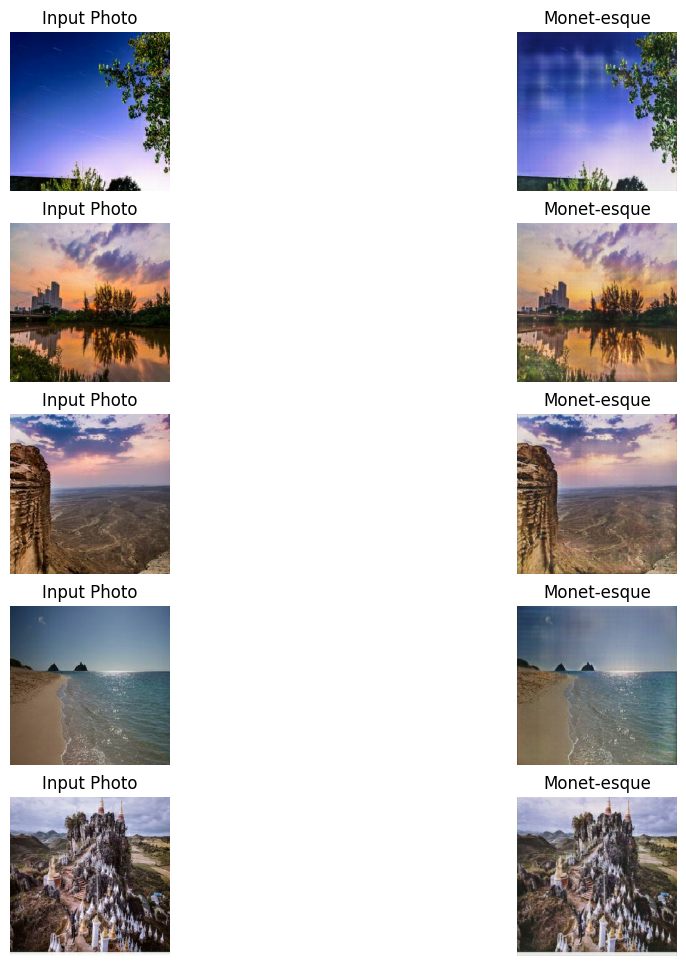

In [34]:
# model 5
# uses newGenerator() and newDiscriminator3()
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(trainPhotos.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

## Model 2
This model was similar to the previous, however it used less residual connections in hopes that it would not memorize the underlying image, but the features learned from slightly earlier convolutions. This was also not good however and allowed me to move away from the idea of adding residual connections to the discriminator

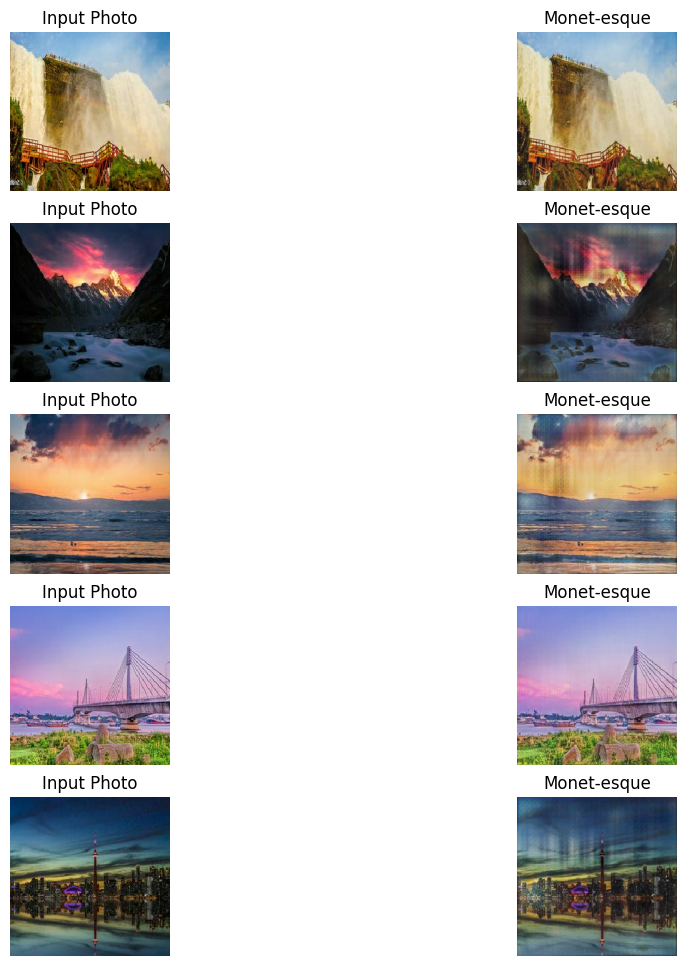

In [34]:
# model 5
# uses newGenerator() and newDiscriminator3()
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(trainPhotos.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

## Model 3
For this model, I used the generator starting with 64 filters and increased to 1024. I then copied and reversed the architecture to rebuild back to (256,256,3). I used residual connections to imitate a U-net architecture as well in the generators. For the discriminator I added convolution layers until it was of shape (1,1,filters). This proved to not be a good way of learning the feature representation however as it looked at individual pixels.

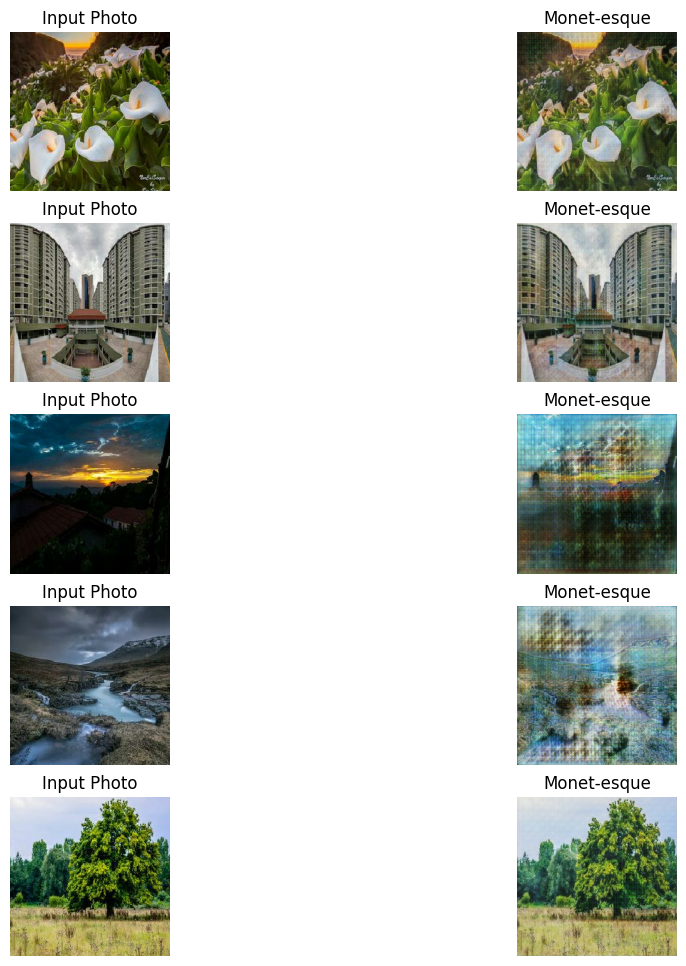

In [40]:
# model 4
# uses newGenerator() and newDiscriminator2()
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(trainPhotos.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

## Model 4
For this model, I used the generator starting with 64 filters and increased to 1024. I then copied and reversed the architecture to rebuild back to (256,256,3). I used residual connections to imitate a U-net architecture as well in the generators. For the discriminator I added convolution layers until it was of shape (1,1,filters). This proved to not be a good way of learning the feature representation however as it looked at individual pixels.

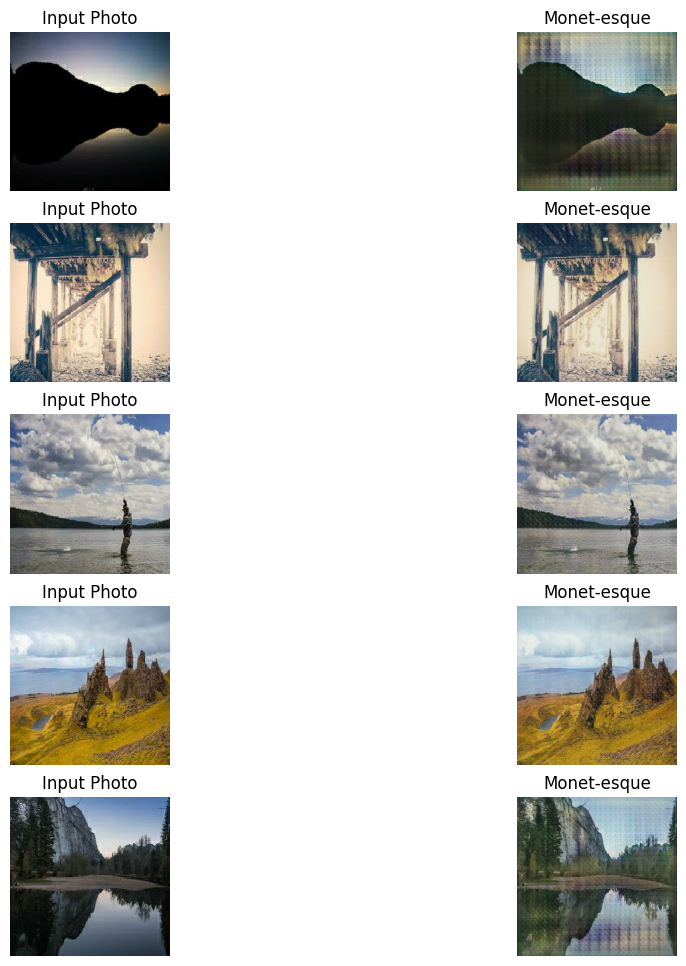

In [34]:
# model 4
# uses newGenerator() and newDiscriminator2()
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(trainPhotos.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

## Model 5
For this model, I used the generator starting with 64 filters and increased to 1024. I then copied and reversed the architecture to rebuild back to (256,256,3). I used residual connections to imitate a U-net architecture as well in the generators. For the discriminator I added convolution layers until it was of shape (1,1,filters). This proved to not be a good way of learning the feature representation however as it looked at individual pixels.

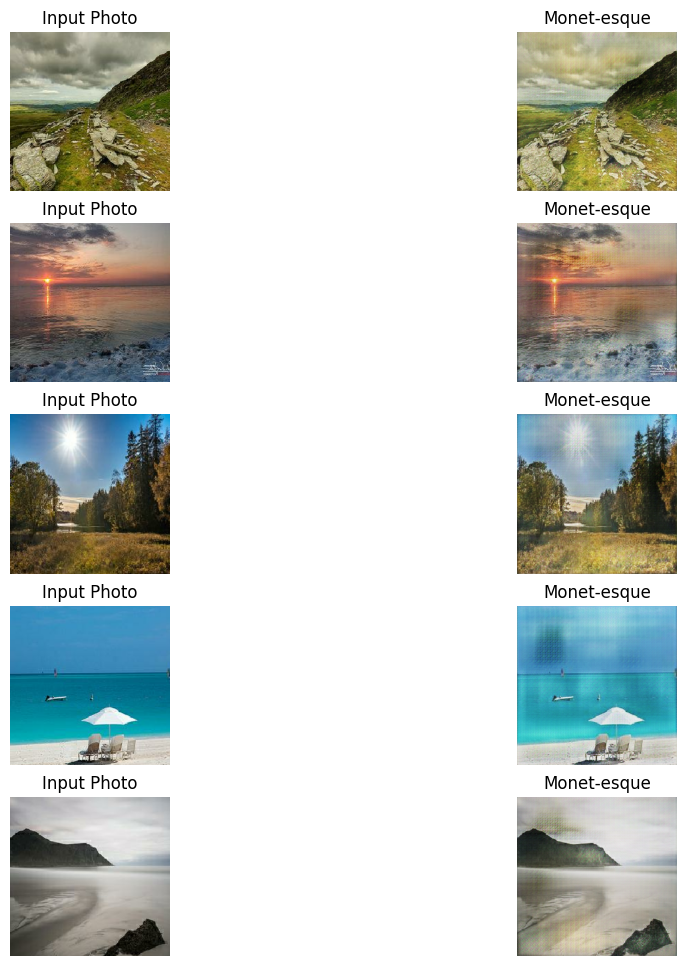

In [31]:
# model 3
# uses newGenerator() and newDiscriminator2()
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(trainPhotos.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

## Model 6
For this model, I used the generator starting with 64 filters and increased to 1024. I then copied and reversed the architecture to rebuild back to (256,256,3). I used residual connections to imitate a U-net architecture as well in the generators. From empirical results, this model was second best at learning the actual art style and applying it to the photos. We can see that in some photos it memorized the original representation and did not actually apply a style to it. This could be due to the large number of paramaters

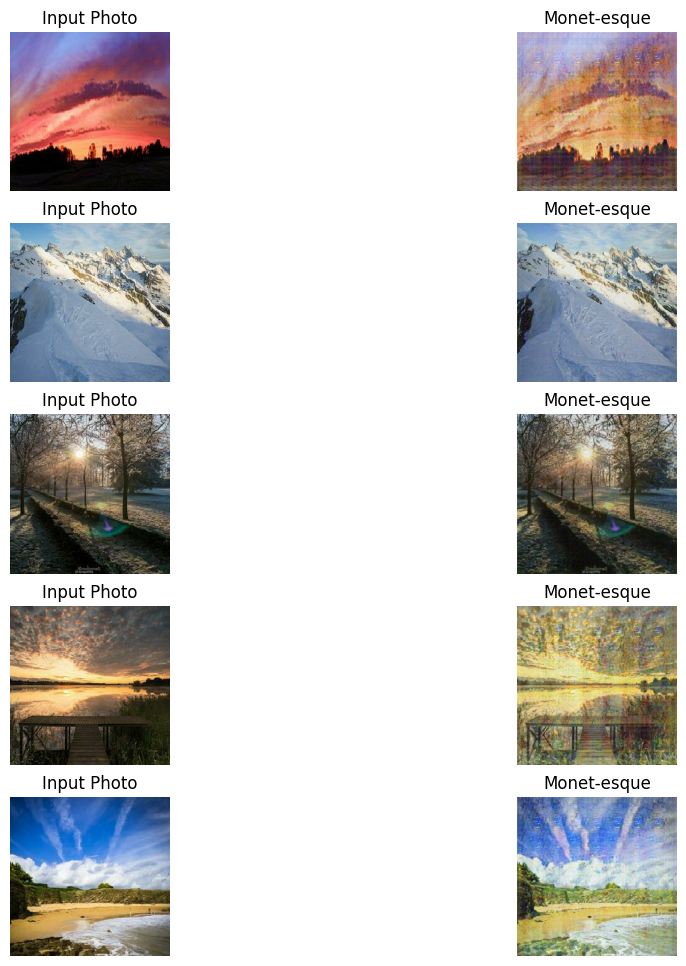

In [30]:
# Model 2
# uses Generator 2 and original discriminator
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(trainPhotos.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

## Model 7
For this model, I used the generator starting with 32 filters and increased to 512. I then copied and reversed the architecture to rebuild back to (256,256,3). I used residual connections to imitate a U-net architecture as well in the generators. From empirical results, this model was best at learning the actual art style and applying it to the photos.

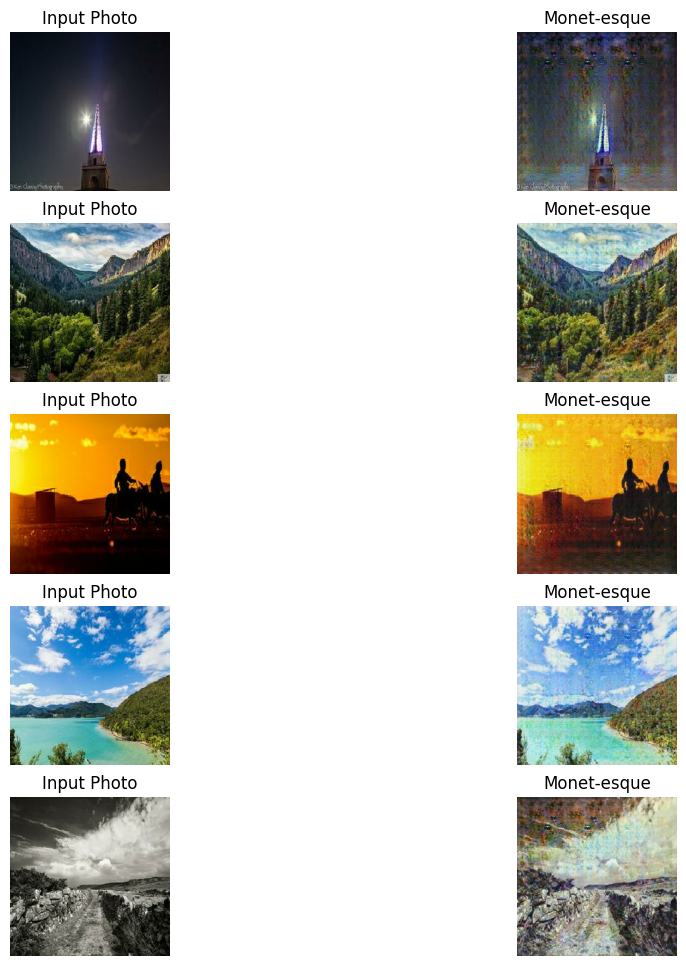

In [30]:
# original model
# uses my Generator and original discriminator
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(trainPhotos.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

# Discussion and Conclusions
The best model appeared to be a U-Net style architecture with a discriminator similar to PatchGAN. This style of cycleGAN is similar to what was used in the original project that this one was based on, however it implements the generator slightly differently

## Limitations
One of the limitations to this project was the short time frame to learn about cycleGAN. In lectures A normal GAN was discussed as well as variational GANs. This means that there was a short amount of time to learn the formation of a CycleGAN. This means that a lot of the inspiration for this project came from previous notebooks which also took time to analyze.

## Future
In the future I would like to perform more research into different methods of generators and discriminators. One paper that was briefly looked into discussed a way to halve the runtime by eliminating the need for a generator and discriminator. Another improvement would be in the loss functions. Because these intuitively seemed to make sense to me, I could not think of other ways to alter these besides altering the LAMBDA value. I would like to explore ways to alter the loss functions or overall training function for the CycleGAN.